Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [85]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [41]:
# Start with splitting train data into train and validation set

target = 'status_group'

train, val = train_test_split(train, test_size=len(test), random_state=25,
                              stratify=train[target])

train.shape, val.shape, test.shape

((30684, 42), (14358, 42), (14358, 41))

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Start with splitting train data into train and validation set

target = 'status_group'

train, val = train_test_split(train, test_size=len(test), random_state=25,
                              stratify=train[target])

# Utilize wrangle function for data cleaning and feature engineering

def wrangle(df):
    """Wrangle train, validate, and test sets in the same way."""
    
    # Create copy to prevent warnings
    df = df.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    df['latitude'] = df['latitude'].replace(-2e-08, 0)
    
    # Some columns have zeros but probably shouldn't, so replace the zeros with 
    # nulls - will impute later with pipeline
    cols_with_zeros = ['longitude', 'latitude','construction_year','gps_height',
                       'population']
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)

    # Payment, management, extraction_type, extraction_type_group, source and
    # waterpoint_type all seem redundant, so drop them. Also, id and
    # recorded_by are not useful for this problem.
    df = df.drop(columns=['payment','id','recorded_by'])
    
    # Convert date_recorded to only include year 
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], yearfirst=True)
    df['date_recorded'] = df['date_recorded'].dt.year

    # Construction year looks like it may be relevant, so I'll see if the time 
    # from inspection has a similar correlation to status_group
    df['construction_vs_inspection_years'] = (df['construction_year'] - df['date_recorded'])

    # 'water_quality' looks interesting as I may expect water sources that produce
    # anything other than "soft" water may have some issues ...
    df['water_is_soft'] = (df['water_quality']=='soft').astype(int)  

    # 'quantity' of the water should tell us something if it's anything other
    # than 'enough'
    df['enough_water'] = (df['quantity']=='enough').astype(int)
    
    # Noticed that majority of these waterpoints do not have a name, and I would
    # think that a waterpoint built with care/pride would be named. 
    df['has_name'] = (df['wpt_name']!='none').astype(int)
    
    # return the wrangled dataframe
    return df

# Apply function
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Define features, x feature matrices and y target vectors
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=322, random_state=42, n_jobs=-1, min_samples_split=3,
                          min_samples_leaf=1, max_depth=25)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print(f'Validation Accuracy: {accuracy_score(y_val, y_pred):%}')

Validation Accuracy: 81.139434%


In [130]:
cols = train.columns
cols

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'construction_vs_inspection_years', 'water_is_soft', 'enough_water',
       'has_name'],
      dtype='object')

In [131]:
data = train.copy()
encoder = ce.OrdinalEncoder()
imputer = SimpleImputer(strategy='mean')
data_encoded = encoder.fit_transform(data)
data_imputed = imputer.fit_transform(data_encoded)
data_imputed = pd.DataFrame(data_imputed, columns=cols)
data_imputed.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,construction_vs_inspection_years,water_is_soft,enough_water,has_name
0,100.0,2013.0,1.0,68.000000,1.0,39.098522,-6.957068,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-3.000000,1.0,1.0,0.0
1,0.0,2013.0,2.0,945.000000,2.0,36.885462,-3.526118,2.0,0.0,2.0,...,2.0,2.0,1.0,2.0,1.0,2.0,-39.000000,1.0,0.0,1.0
2,0.0,2012.0,3.0,1020.389729,3.0,32.934771,-3.382435,3.0,0.0,3.0,...,1.0,1.0,1.0,3.0,2.0,2.0,-15.411716,1.0,1.0,1.0
3,0.0,2011.0,4.0,1020.389729,4.0,31.429279,-1.680496,4.0,0.0,3.0,...,3.0,3.0,2.0,1.0,1.0,1.0,-15.411716,1.0,0.0,1.0
4,50.0,2013.0,1.0,6.000000,1.0,39.182388,-6.930436,5.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-3.000000,1.0,1.0,1.0


In [134]:
data.corr()
# Was using this to get ideas for further feature engineering, but struggled to 
# find new ideas!

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,construction_vs_inspection_years,water_is_soft,enough_water,has_name
amount_tsh,1.000000,-0.004006,0.049548,0.009965,-0.064397,0.002433,-0.033400,-0.029973,-0.005100,0.005729,0.009029,0.029228,0.047125,-0.076207
date_recorded,-0.004006,1.000000,0.094087,0.119761,0.159209,-0.009674,0.164966,0.016725,0.043021,0.016736,-0.061472,-0.025146,-0.059856,0.231509
gps_height,0.049548,0.094087,1.000000,-0.570996,0.279598,-0.010568,-0.318104,-0.330090,-0.032478,-0.012978,-0.020898,0.184888,0.093865,-0.311750
longitude,0.009965,0.119761,-0.570996,1.000000,-0.298100,0.039129,0.144733,0.248987,-0.109790,0.026954,0.033953,-0.079739,-0.039318,0.015935
latitude,-0.064397,0.159209,0.279598,-0.298100,1.000000,0.010774,-0.242174,-0.192425,0.051190,0.038599,0.017062,-0.023116,-0.017808,0.233871
num_private,0.002433,-0.009674,-0.010568,0.039129,0.010774,1.000000,-0.021256,-0.005185,-0.011294,-0.004935,-0.003258,0.005011,0.001239,0.007676
region_code,-0.033400,0.164966,-0.318104,0.144733,-0.242174,-0.021256,1.000000,0.679666,0.081961,-0.009670,-0.022403,-0.087110,0.023414,0.051039
district_code,-0.029973,0.016725,-0.330090,0.248987,-0.192425,-0.005185,0.679666,1.000000,0.035350,0.011825,0.009283,-0.055170,-0.025969,0.055183
population,-0.005100,0.043021,-0.032478,-0.109790,0.051190,-0.011294,0.081961,0.035350,1.000000,0.029792,0.026360,-0.038964,-0.015923,0.057195
construction_year,0.005729,0.016736,-0.012978,0.026954,0.038599,-0.004935,-0.009670,0.011825,0.029792,1.000000,0.996940,0.021525,0.124914,-0.009994


# Plot a confusion matrix for your Tanzania Waterpumps model.

In [6]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


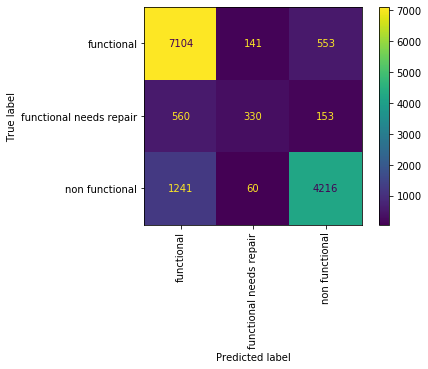

In [137]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', 
                      xticks_rotation='vertical');

In [140]:
correct_preds_nf = 4216
total_preds_nf = 4216+153+553
nf_precision = correct_preds_nf / total_preds_nf
print(f'Precision of "non functional" predictions: {nf_precision:%}')

Precision of "non functional" predictions: 85.656237%


In [142]:
true_nf = 1241 + 60 + 4216
nf_recall = correct_preds_nf / true_nf
print(f'Recall of "non functional" predictions: {nf_recall:%}')

Recall of "non functional" predictions: 76.418343%
